In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *
from models import RMLPClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
#datadir = '../data/immunomodulation/log_normalized/suppress_1std/'
datadir = '/home/jshe/prop-pred/src/data/immunomodulation/log_normalized/enhance_05std'
data = to_namedtuple(to_tensor(load_data(datadir), device))

In [3]:
train_X = torch.concat((
    data.train.embeddings, 
    data.train.fingerprints
), axis=1)
validation_X = torch.concat((
    data.validation.embeddings, 
    data.validation.fingerprints
), axis=1)
test_X = torch.concat((
    data.test.embeddings, 
    data.test.fingerprints
), axis=1)

In [4]:
train_Y = torch.concat((
    data.train.y, 
    #data.train.y_rdkit, 
), axis=1)
validation_Y = torch.concat((
    data.validation.y, 
    #data.validation.y_rdkit
), axis=1)
test_Y = torch.concat((
    data.test.y, 
    #data.test.y_rdkit, 
), axis=1)

## Model

In [5]:
mlp = RMLPClassifier(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=2, width=512, dropout=0.5
).to(device)

## Train

 12%|█████▎                                    | 64/512 [02:07<14:52,  1.99s/it]


Val.: 0.5957
Test: 0.6213


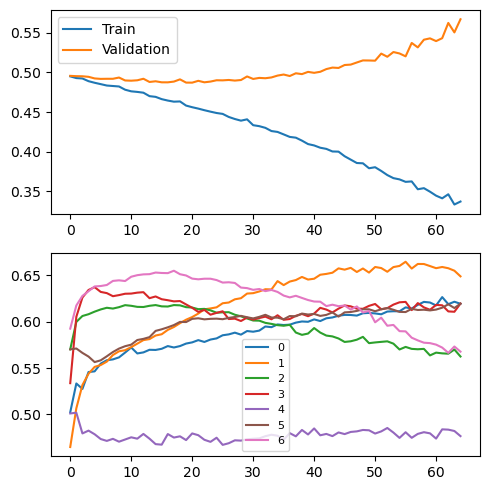

In [6]:
validation_score = mlp.fit(
    train_X, train_Y, 
    validation_X, validation_Y, 
    lr=0.00005, epochs=512, batch_size=32, 
    early_stopping=True, plot=True
)
test_score = mlp.score(test_X, test_Y)

print(f'Val.: {validation_score:.4f}')
print(f'Test: {test_score:.4f}')

## Visualization

In [7]:
y_pred = mlp(test_X).detach().cpu()
y_pred_binary = (y_pred > 0.5).to(int)

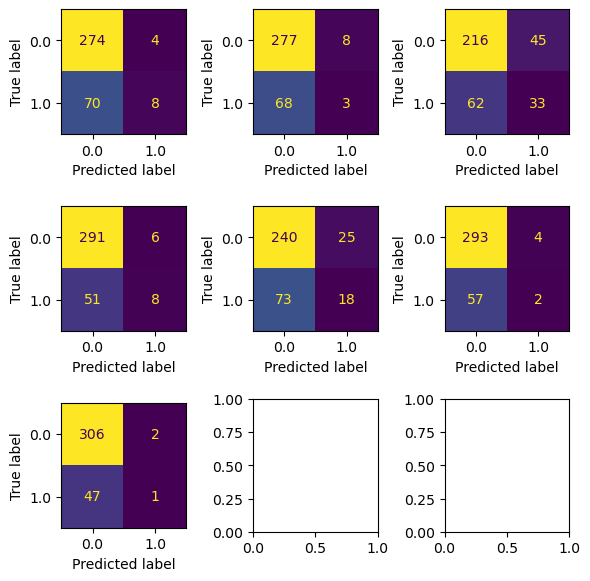

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
axs = axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ConfusionMatrixDisplay.from_predictions(
        test_Y[:, i].cpu(), y_pred_binary[:, i].cpu(), 
        ax=ax, colorbar=False
    )

plt.tight_layout()

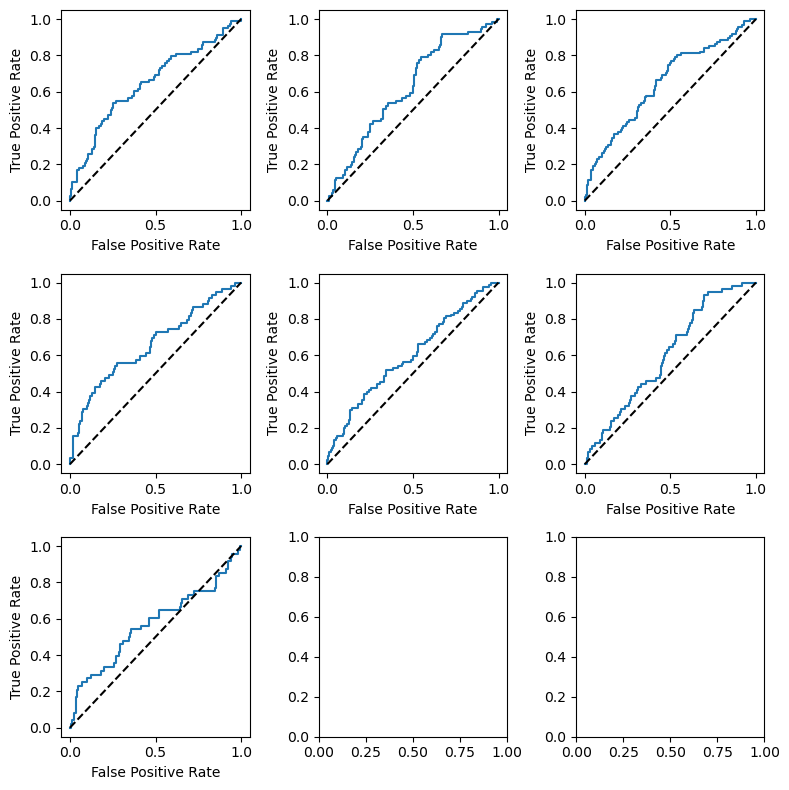

In [9]:
from sklearn.metrics import RocCurveDisplay

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    RocCurveDisplay.from_predictions(
        test_Y[:, i].cpu(), y_pred[:, i].cpu(), 
        ax=ax, plot_chance_level=True
    )
    #ax.set_title(property_label)
    ax.get_legend().remove()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

plt.tight_layout()